<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/18045/logos/header.png?t=2020-02-21-18-37-17" width=1900px height=400px />

# Ion Switching
## Drift Removal + Feature Engineering + Overfitting (Train)

<h3 style="color:red"> If this Kernel Helped You! Please UP VOTE! 😁 </h3>

<h3> Kernel description: </h3>


What I love most about Kaggle is the sharing of solutions. For me, it is far from a competition. Kaggle is the true meaning of research, that is, the combination of several ideas from different people to find the solution to a problem.

This Kernel uses ideas from me and other authors. The main ideas are the removal of the signal Drift, presented by @cdeotte, Feature Engineering from the work of @jazivxt and implementation of @ kmat2019 of a [discussion](https://www.kaggle.com/c/liverpool-ion-switching/discussion/133142) that proved that the first 30% of the test data is used to calculate public score. Below, the link to the mentioned notebooks.

* Drift Removal: https://www.kaggle.com/cdeotte/one-feature-model-0-930
* Feature Engineering: https://www.kaggle.com/jazivxt/physically-possible
* Overfitting (Train): https://www.kaggle.com/kmat2019/train-test-similarity-analysis



# Table of Contents:

**1. [Problem Definition](#id1)** <br>
**2. [Get the Data (Collect / Obtain)](#id2)** <br>
**3. [Load the Dataset](#id3)** <br>
**4. [Data Pre-processing](#id4)** <br>
**5. [Model](#id5)** <br>
**6. [Visualization and Analysis of Results](#id6)** <br>
**7. [Submittion](#id7)** <br>
**8. [References](#ref)** <br>

<a id="id1"></a> <br> 
# **1. Problem Definition:** 
<img src="https://www.news-medical.net/image.axd?picture=2018%2F10%2Fshutterstock_480412786.jpg" />

Many diseases, including cancer, are believed to have a contributing factor in common. Ion channels are pore-forming proteins present in animals and plants
If scientists could better study ion channels, it could have a far-reaching impact.

Ion channels are pore-forming proteins present in animals and plants. They encode learning and memory, help fight infections, enable pain signals, and stimulate muscle contraction.

In this competition, you’ll use ion channel data to better model automatic identification methods. If successful, you’ll be able to detect individual ion channel events in noisy raw signals.

<a id="id2"></a> <br> 
# **2. Get the Data (Collect / Obtain):** 
> Loading all libs and necessary datasets

In [66]:
import numpy as np 
import pandas as pd
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

sns.set_style("whitegrid")

from sklearn.model_selection import KFold

#Constants
ROW_PER_BATCH = 500000

In [67]:
#Loading data
train = pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv')
test = pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv')


print('Shape of train is ',train.shape)
print('Shape of test is ',test.shape)

Shape of train is  (5000000, 3)
Shape of test is  (2000000, 2)


<a id="id3"></a> <br> 
# **3. Understand the Data** 

While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001.

In [68]:
train['batch'] = 0

for i in range(0, train.shape[0]//ROW_PER_BATCH):
    train.iloc[i * ROW_PER_BATCH: (i+1) * ROW_PER_BATCH,3] = i

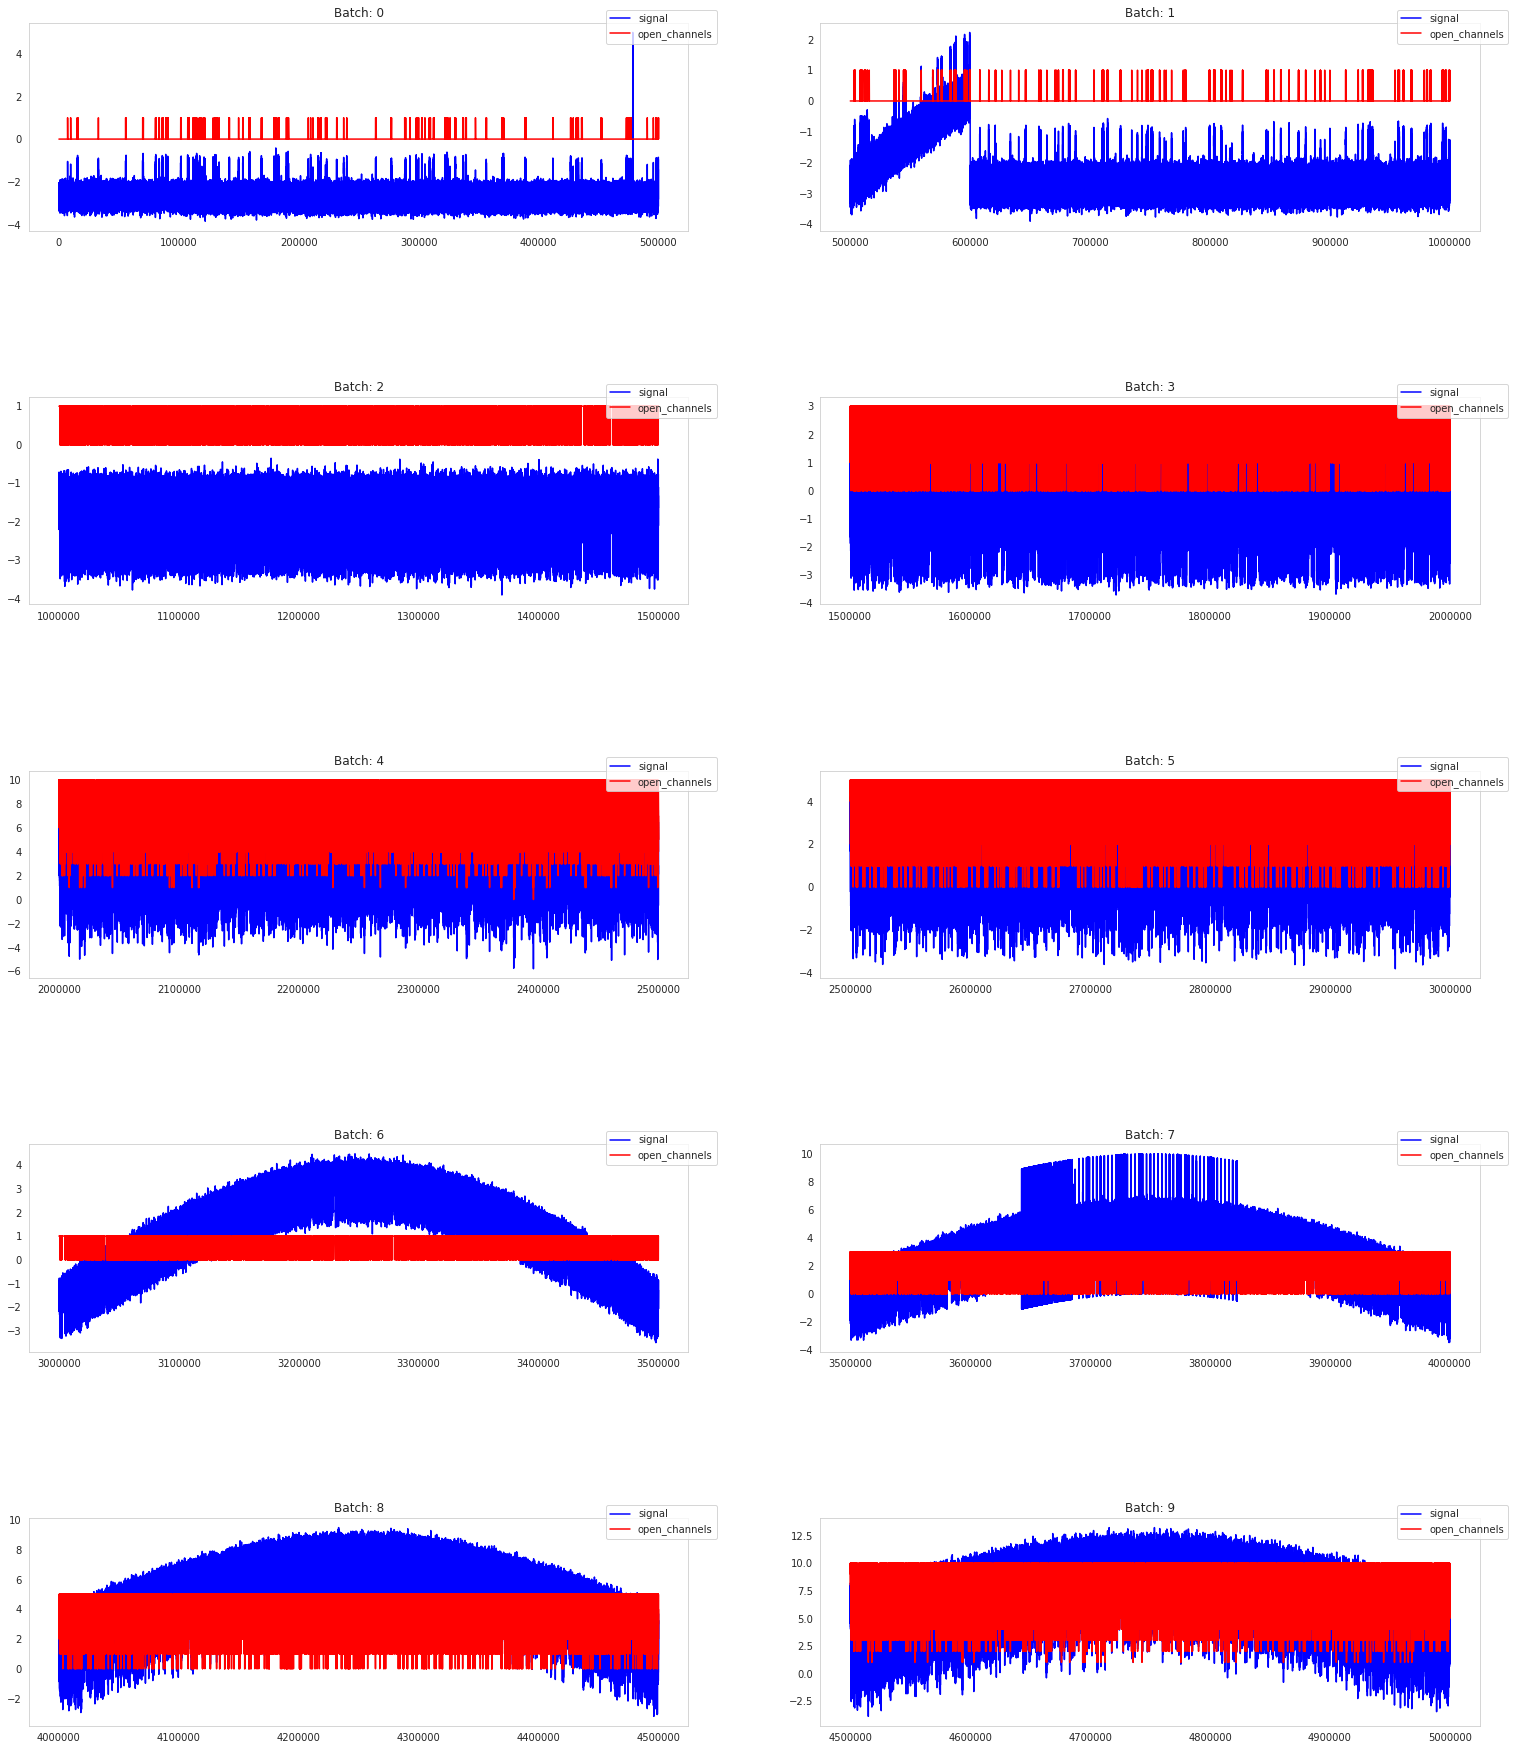

In [69]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(train['batch'].unique()):
    plt.subplot(5, 2, i + 1)
    plt.plot(train.loc[train['batch'] == b, ['signal']], color='b')
    plt.title(f'Batch: {b}')
    plt.plot(train.loc[train['batch'] == b, ['open_channels']], color='r')
    plt.legend(['signal', 'open_channels'], loc=(0.875, 0.9))
    plt.grid(False)

### Findings

1) batch 0: It looks like the most stable data part. Where you can clearly see the signs and open channels for correspondence. In this graph, open_channels are binary events with low probability<br>
2) batch 1: There also appears to be a certain correlation, even though there is a shift in signal levels after the 600k time. In this graph, open_channels are binary events with LOW probability.<br>
3) batch 2 and 6: open_channels are binary events with HIGH probability<br>
**4) A Drift was added to batches 6, 7, 8, 9. And the beginning of batch 1.**

## Interesting Pattern 

It can be seen a patern batches, for every batch there is another with almost identical target distribution, same color here.

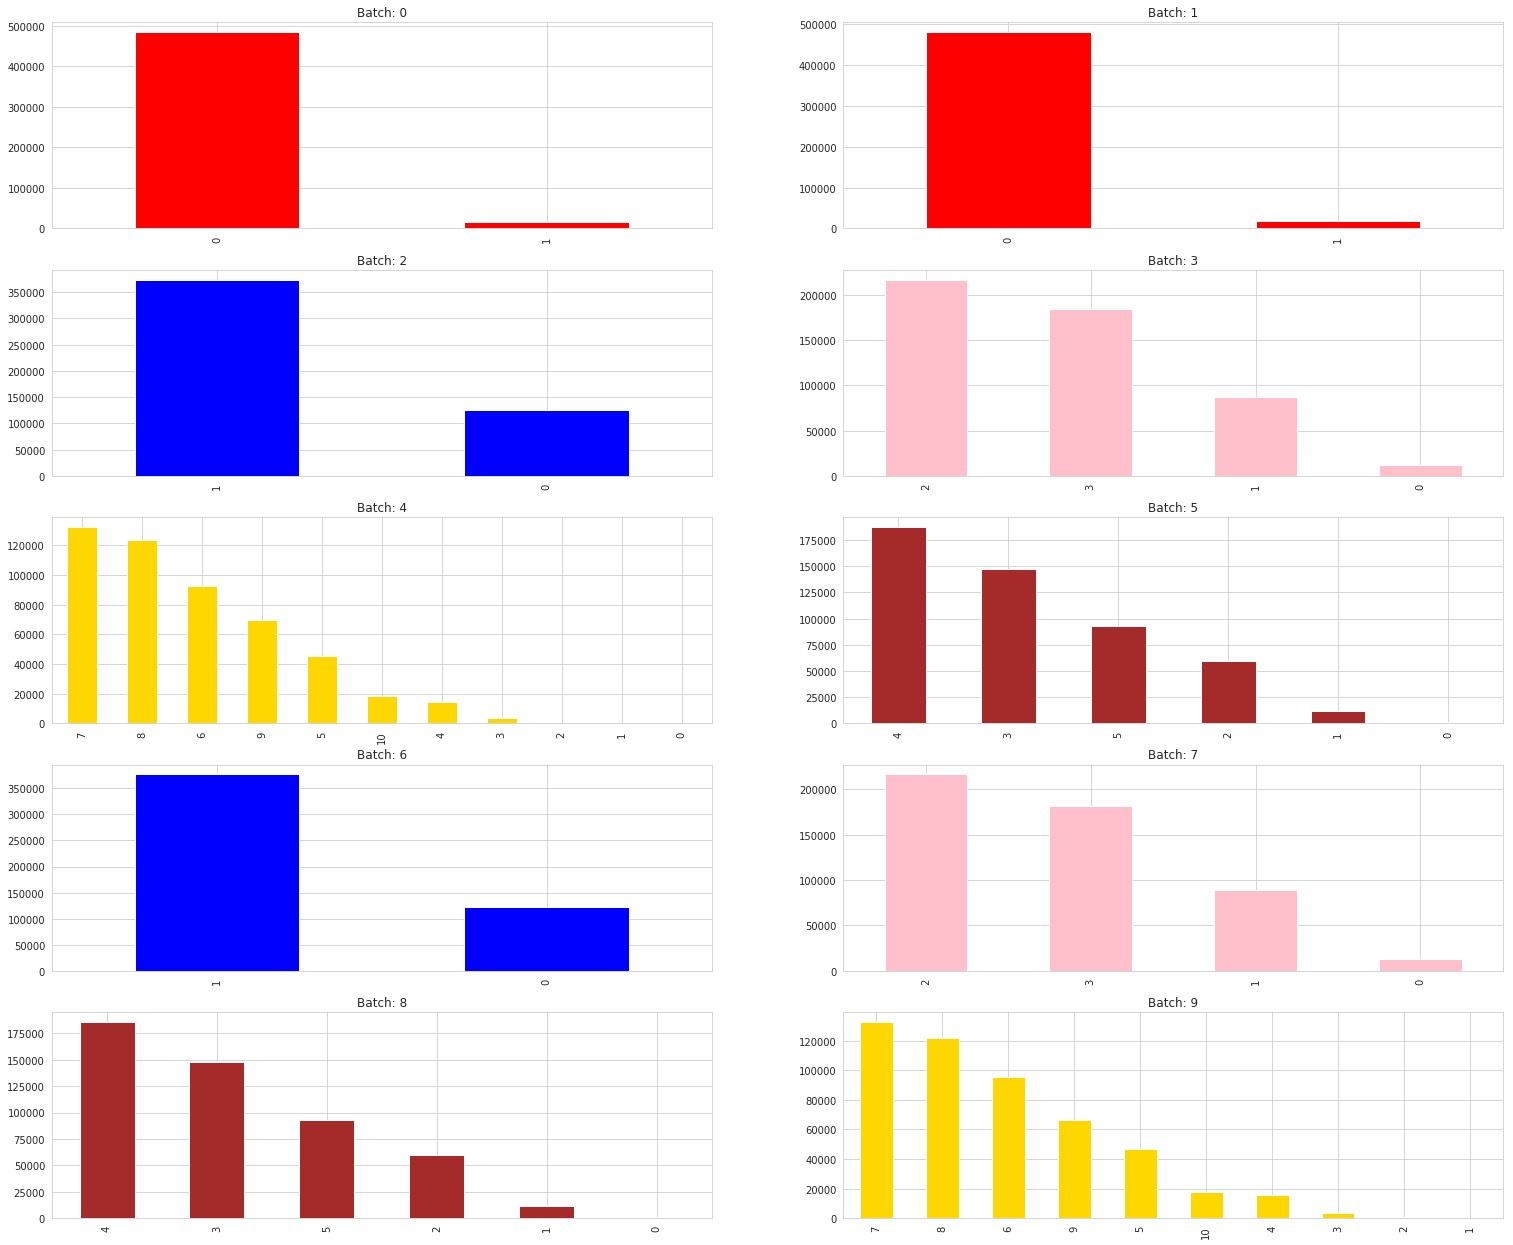

In [70]:
plt.figure(figsize=(26, 22))
colors = ['red','red','blue','pink','gold','brown','blue','pink','brown','gold']
for i, b in enumerate(train['batch'].unique()):
    plt.subplot(5, 2, i + 1)
    train.iloc[i*ROW_PER_BATCH : (i+1)*ROW_PER_BATCH]['open_channels'].value_counts().plot(kind='bar',color= colors[i])
    plt.title(f'Batch: {b}')

### Chacing distribution

Just checking the distribution to seek for 

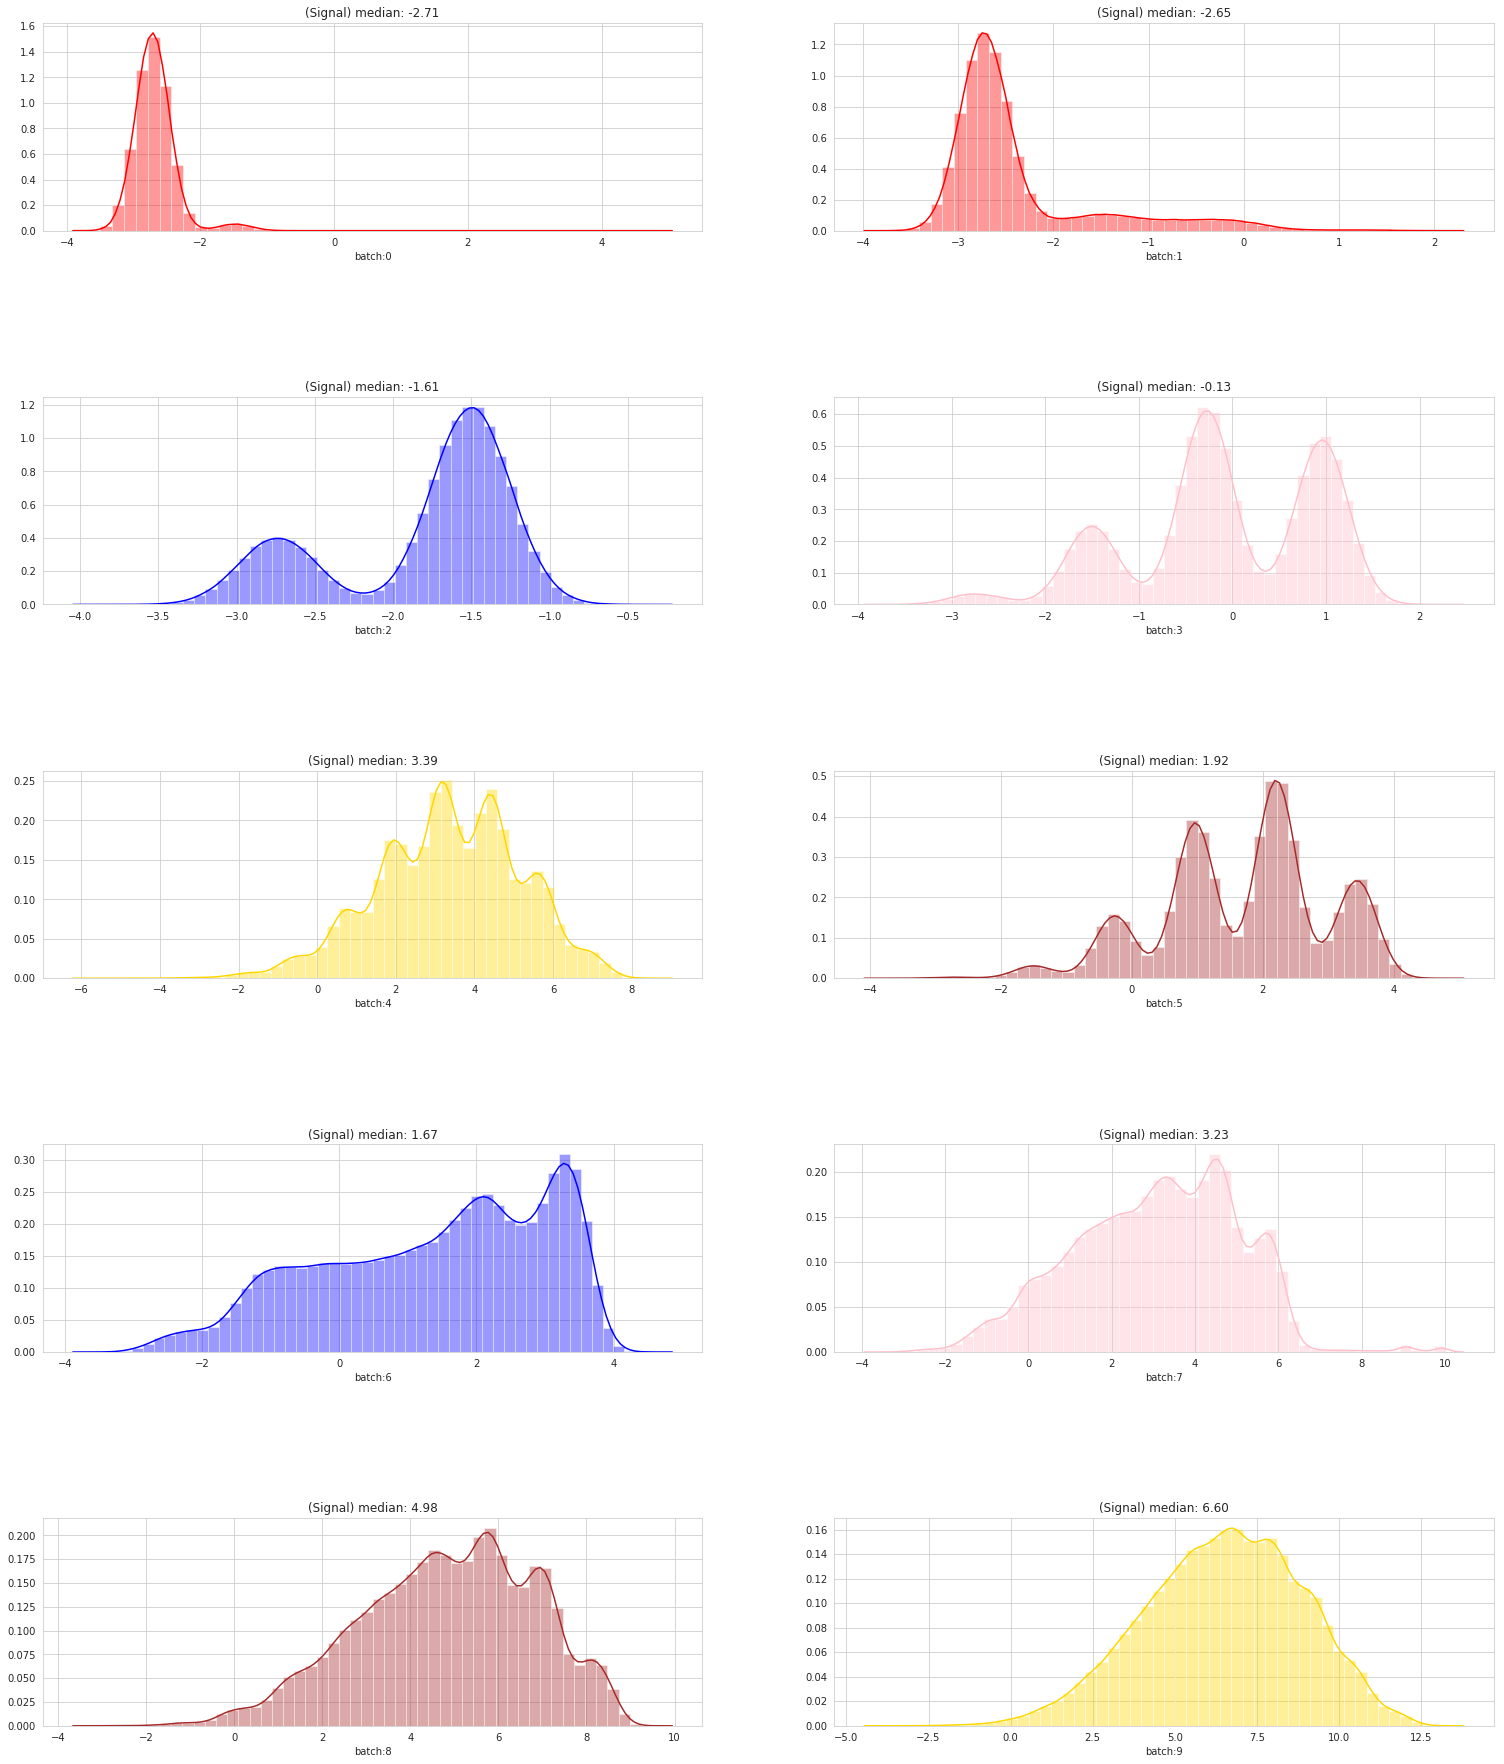

In [71]:
df = pd.DataFrame()
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
colors = ['red','red','blue','pink','gold','brown','blue','pink','brown','gold']
for i in train['batch'].unique():
    df[ f'batch:{i}' ] = train.iloc[i*ROW_PER_BATCH : (i+1)*ROW_PER_BATCH].reset_index().signal 
    plt.subplot(5, 2, i + 1)
    
    sns.distplot(df[f'batch:{i}'], color= colors[i]).set_title(f"(Signal) median: {df[f'batch:{i}'].median():.2f}")

    


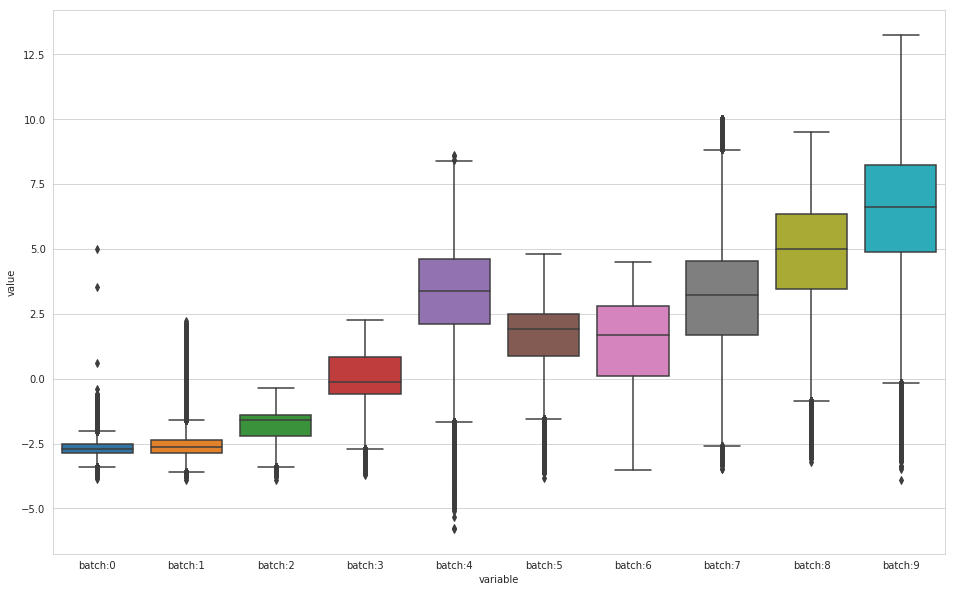

In [72]:
plt.figure(figsize=(16,10))

sns.boxplot(x="variable",y="value",data=pd.melt(df))

# Test Data Analisys

In [73]:
test['batch'] = 0

for i in range(0, test.shape[0]//ROW_PER_BATCH):
    test.iloc[i * ROW_PER_BATCH: (i+1) * ROW_PER_BATCH,2] = i

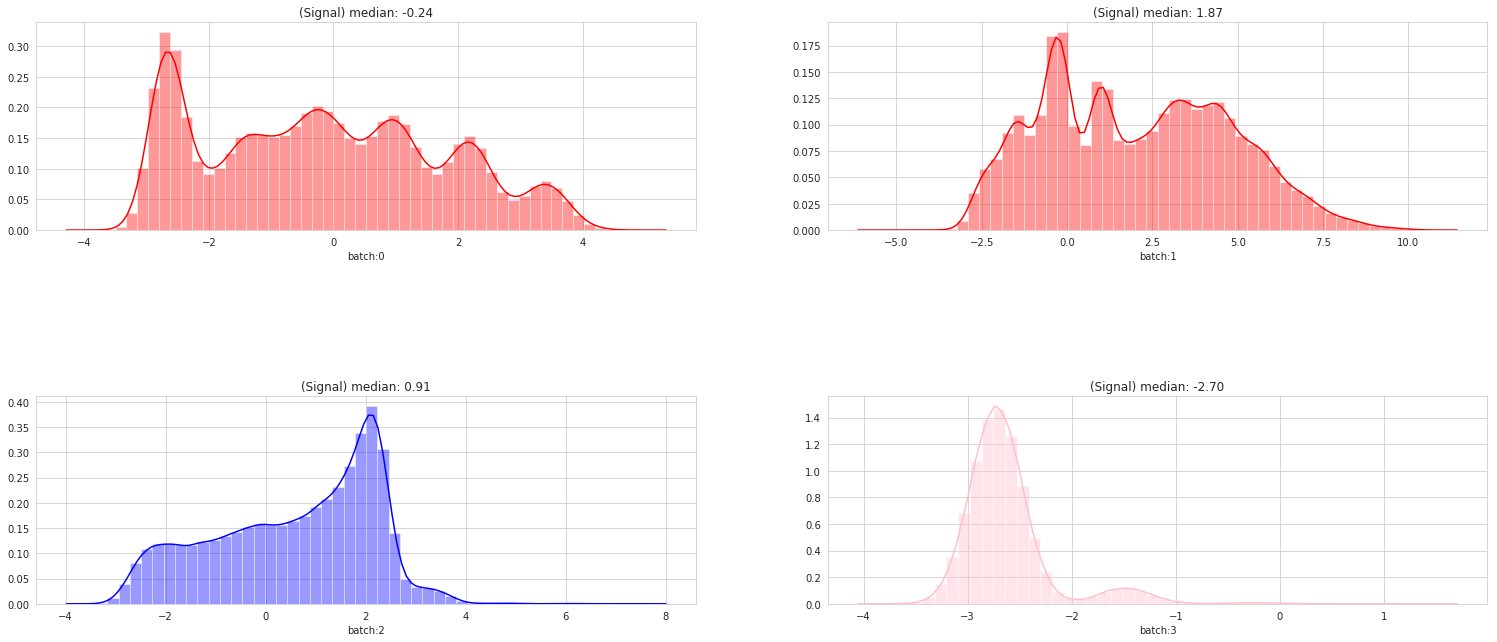

In [74]:
mean_signal = []
df = pd.DataFrame()
templis = {}
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
colors = ['red','red','blue','pink','gold','brown','blue','pink','brown','gold']
for i in test['batch'].unique():
    df[ f'batch:{i}' ] = test.iloc[i*ROW_PER_BATCH : (i+1)*ROW_PER_BATCH].reset_index().signal 
    plt.subplot(5, 2, i + 1)
    sns.distplot(df[f'batch:{i}'], color= colors[i]).set_title(f"(Signal) median: {df[f'batch:{i}'].median():.2f}")

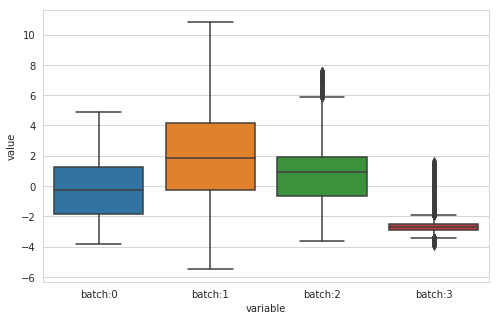

In [75]:
plt.figure(figsize=(8,5))
sns.boxplot(x="variable",y="value",data=pd.melt(df))

The idea here is identify some patterns and then create groups from these patterns to split the data. After that, we can make diferente models for each of patterns. For now, I'm not using this idea, but I will later.

In [76]:
train['type'] = 0
for i in range(train['batch'].nunique()):
    median = train.iloc[i*ROW_PER_BATCH : (i+1) * ROW_PER_BATCH].signal.median()
    if (median < 0):
        train.iloc[i*ROW_PER_BATCH : (i+1) * ROW_PER_BATCH, train.columns.get_loc('type')] = 0
    else:
        train.iloc[i*ROW_PER_BATCH : (i+1) * ROW_PER_BATCH, train.columns.get_loc('type')] = 1
        
test['type'] = 0

ROW_PER_BATCH = 100000

for i in range(test['batch'].nunique()):
    median = test.iloc[i*ROW_PER_BATCH : (i+1)*ROW_PER_BATCH].signal.median()
    if (median < 0):
        test.iloc[i*ROW_PER_BATCH : (i+1) * ROW_PER_BATCH, test.columns.get_loc('type')] = 0
    else:
        test.iloc[i*ROW_PER_BATCH : (i+1) * ROW_PER_BATCH, test.columns.get_loc('type')] = 1    

## Remove Drift from Training Data
from: https://www.kaggle.com/cdeotte/one-feature-model-0-930


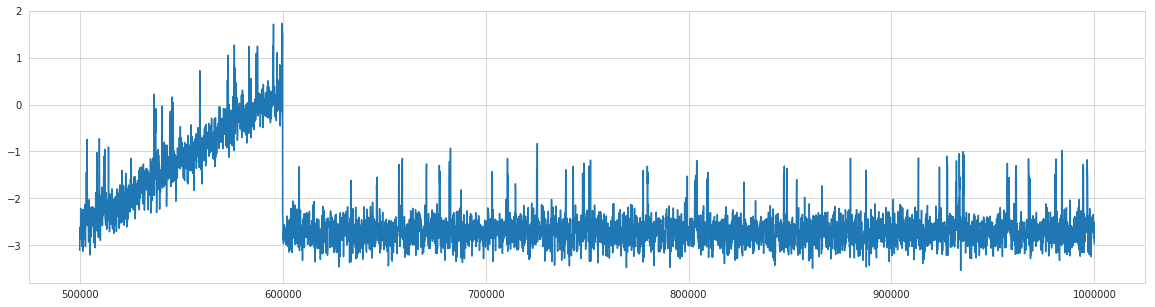

In [77]:
plt.figure(figsize=(20,5))
plt.plot( train.signal[500000:1000000][::100] )
plt.show()

### Checking if this changes the data distribution.

In [ ]:
a = 500000; b = a *2
print( 'Before: mean: {} std: {} median: {}'.format( train.signal[a:b].mean(), train.signal[a:b].std(),train.signal[a:b].median() ) )

a=500000; b=600000
train['signal_undrifted'] = train.signal
train.loc[train.index[a:b],'signal_undrifted'] = train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10.

a = 500000; b = a *2
print( 'After: mean: {} std: {} median: {}'.format( train.signal_undrifted[a:b].mean(), train.signal_undrifted[a:b].std(),train.signal_undrifted[a:b].median() ) )

In [ ]:
plt.figure(figsize=(20,5))
plt.plot( train.signal_undrifted[500000:1000000][::100] )
plt.show()

As we can see in figure below, the drift removal makes signal closer to a normal distribution.

In [ ]:
plt.figure(figsize=(20,6))
sns.distplot(train.signal[500000:1000000],color='r')
sns.distplot(train.signal_undrifted[500000:1000000],color='g' ).set(xlabel="Signal")
plt.legend(labels=['Original Signal','Undrifted Signal'])


### Removing Drift from Batch 7-10

In [ ]:

def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(train.time[::1000],train.signal[::2000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(train.time[::1000],train.signal_undrifted[::2000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Train Data',loc='upper left', labels=['Original Signal', 'UnDrifted Signal'])
plt.show(g)



In [ ]:
test['signal_undrifted'] = test.signal

# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - f(test.time[a:b].values)

## Remove Drift from Test Data

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(test.time[::1000],test.signal[::1000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(test.time[::1000],test.signal_undrifted[::1000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Test Data',loc='upper right', labels=['Original Signal', 'UnDrifted Signal'])
plt.show(g)



<a id="id5"></a> <br> 
# **5. Feature Engineering** 

In [ ]:
%%time

def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal_undrifted'].mean()
        d['median'+c] = df.groupby([c])['signal_undrifted'].median()
        d['max'+c] = df.groupby([c])['signal_undrifted'].max()
        d['min'+c] = df.groupby([c])['signal_undrifted'].min()
        d['std'+c] = df.groupby([c])['signal_undrifted'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal_undrifted'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal_undrifted'].values[:-1])
    df['signal_shift_-1'] = list(df['signal_undrifted'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal_undrifted', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal_undrifted']
        
    return df

train = features(train)
test = features(test)

<a id="id5"></a> <br> 
# **6. Model**

> Simple Model: It's can be improved.

In [ ]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average="macro")
    return ('KaggleMetric', score, True)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='f1score',
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=50, early_stopping_rounds=200, n_estimators=2000):

    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {
                    'f1score': {'lgb_metric_name': lgb_Metric,}
                   }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X) )
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    '''for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]'''
            
    if True:        
        X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=7)    
            
        if model_type == 'lgb':
            #model = lgb.LGBMClassifier(**params, n_estimators=n_estimators)
            #model.fit(X_train, y_train, 
            #        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
            #       verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            model = lgb.train(params, lgb.Dataset(X_train, y_train),
                              n_estimators,  lgb.Dataset(X_valid, y_valid),
                              verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds, feval=lgb_Metric)
            
            
            preds = model.predict(X_valid, num_iteration=model.best_iteration) #model.predict(X_valid) 
            y_pred_valid = np.round(np.clip(preds, 0, 10)).astype(int)

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)

 
        #oof[valid_index] = y_pred_valid
        scores.append(f1_score_calc(y_valid, y_pred_valid ) )

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [ ]:
#Let's uses 'singal_undrifted' instead of 'signal'
good_columns = [c for c in train.columns if c not in ['time', 'signal','open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

X = train[good_columns].copy()
y = train['open_channels']
X_test = test[good_columns].copy()

In [ ]:
del train, test

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 7, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1}

result_dict_lgb = train_model_classification(X=X[0:500000*8-1], X_test=X_test, y=y[0:500000*8-1], params=params, model_type='lgb', eval_metric='f1score', plot_feature_importance=False,
                                                      verbose=50, early_stopping_rounds=150, n_estimators=3000)

<a id="id5"></a><br> 
# **7. Results**

The model can score 0.938 on LB without further optimization. Maybe with some GridSearch for parameters tunning or more features engineering, it's possible to get to 0.94

In [ ]:
booster = result_dict_lgb['model']

fi = pd.DataFrame()
fi['importance'] = booster.feature_importance(importance_type='gain')
fi['feature'] = booster.feature_name()

best_features = fi.sort_values(by='importance', ascending=False)[:20]


plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features);
plt.title('LGB Features (avg over folds)');

<a id="id7"></a> <br> 
# **8. Submittion** 

In [ ]:
sub = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.array(np.round(result_dict_lgb['prediction'],0), np.int) 

sub.to_csv('submission_unshifted_70p.csv', index=False, float_format='%.4f')
sub.head(10)

<a id="ref"></a>
# **8. References** 

[1] Deep-Channel uses deep neural networks to detect
single-molecule events from patch-clamp data https://www.nature.com/articles/s42003-019-0729-3.pdf

[2] The Patch Clamp Method: https://www.youtube.com/watch?v=mVbkSD5FHOw

[3] Electophysiology: Patch clamp method https://www.youtube.com/watch?v=CvfXjGVNbmw

[4] The Action Potential https://www.youtube.com/watch?v=HYLyhXRp298

[5] https://www.kaggle.com/pestipeti/eda-ion-switching

[6] https://www.kaggle.com/kmat2019/u-net-1d-cnn-with-keras

[7] https://www.kaggle.com/cdeotte/one-feature-model-0-930

> **Nota**: If you fork my work, please, upvote and give the credits ☺ <br>
Made by[@AdrianoAvelar](https://www.kaggle.com/adrianoavelar) <br>
Fork and Code.
<h3 style="color:red"> If this Kernel Helped You! Please UP VOTE! 😁 </h3>